# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {Ayush Poudel, Santosh Luitel}  
Summer Term 2024   

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [ ]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [ ]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Load, clean and split the tabular dataset

**Data description:**  
Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.  

Data is from https://archive.ics.uci.edu/dataset/2/adult

*Disclaimer* numbers below for Neural Networks, etc are outdated, so do not orient on these

**Task:** - download the dataset in python and load it here. Check the dataset size and preliminary artifacts.  

*Hint:*
* How many unique values the target column should have?

In [ ]:
import requests
import zipfile
import io

data_link = "https://archive.ics.uci.edu/static/public/2/adult.zip"



response = requests.get(data_link)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

zip_file.extract("adult.data")
zip_file.extract("adult.test")

column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

train_data = pd.read_csv("adult.data", names = column_names, sep=",")
test_data = pd.read_csv("adult.test", names =column_names, sep=",", skiprows = 1)

train_data['income'] = train_data['income'].str.strip().replace({'<=50K.': '<=50K', '>50K.': '>50K'})
test_data['income'] = test_data['income'].str.strip().replace({'<=50K.': '<=50K', '>50K.': '>50K'})

train_data['income'] = train_data['income'].astype('category')
test_data['income'] = test_data['income'].astype('category')



In [ ]:
# TODO - download the dataset
print(train_data.shape)
print(train_data.iloc[0])



(32561, 15)
age                           39
workclass              State-gov
fnlwgt                     77516
education              Bachelors
education-num                 13
marital-status     Never-married
occupation          Adm-clerical
relationship       Not-in-family
race                       White
sex                         Male
capital-gain                2174
capital-loss                   0
hours-per-week                40
native-country     United-States
income                     <=50K
Name: 0, dtype: object


We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity. Sometimes, even the fact that data is missing could be data itself (think about patients who came or missed doctor appointment). In this case we are going with the most simple way to handle Nans - basically removing such entries.*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 40 items.

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Encode categorical values**   

Use label encodings for categorical variables

*Hint:*
* To make t easier to drop rows with nan values, merge $X$ and $Y$ in the same dataframe

In [ ]:
target_column = 'income'
test_size = 0.2
random_state = 42

In [ ]:
train_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [ ]:
train_data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [ ]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans
    '''
    # TODO
    return df.dropna()


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical
    if it has <= n unique values
    '''
    # TODO
    for col in df.select_dtypes(include=['number']).columns:
        if col not in ignore and df[col].nunique() <= n:
            df[col] = pd.Categorical(df[col])
    return df


def remove_columns_by_n(df, only_categorical, n=10, direction='less', ignore=[target_column]):
    '''

    Remove columns with more or less than n unique values.
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    # TODO
    if only_categorical:
        # Filter columns to only those that are categorical
        cols_to_consider = df.select_dtypes(include=['category', 'object']).columns
    else:
        # Consider all columns
        cols_to_consider = df.columns

    if direction == 'less':
        cols_to_remove = [col for col in cols_to_consider if df[col].nunique() < n and col not in ignore]
    else:
        cols_to_remove = [col for col in cols_to_consider if df[col].nunique() > n and col not in ignore]
    return df.drop(columns=cols_to_remove)



def object_to_categorical(df):
    label_encoders = {}
    for col in df.columns:
        if df[col].dtype == 'object' or col == 'income':  # Explicitly check for 'income'
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    return df

In [ ]:
print(train_data.shape)
df = train_data
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])

df = remove_columns_by_n(df,only_categorical = False, n = 10, direction='less', ignore=[target_column])
df = object_to_categorical(df)
df = remove_columns_by_n(df, only_categorical = False, n=40, direction='more', ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

print(df.shape)
print(df.iloc[0])

(32561, 15)
(32561, 4)
education         9
education-num    13
occupation        1
income            0
Name: 0, dtype: int64


In [ ]:
df.columns

Index(['education', 'education-num', 'occupation', 'income'], dtype='object')

In [ ]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(columns=[target_column])
y = df[target_column]

X_encoded = pd.get_dummies(X)

train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size=test_size, random_state=random_state)



train_y = train_y.values
test_y = test_y.values

print("Shape of train_X:", train_X.shape)
print("Shape of test_X:", test_X.shape)
print("Type of train_y:", type(train_y))
print("Type of test_y:", type(test_y))


Shape of train_X: (26048, 3)
Shape of test_X: (6513, 3)
Type of train_y: <class 'numpy.ndarray'>
Type of test_y: <class 'numpy.ndarray'>


**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the target variable?

## Task 1: Create a GradientBoostingClassifier

In [ ]:
 ## TODO : define the GradientBoostingClassifier,
## train it on the train set and predict on the test set

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(train_X, train_y)

# Predict on the test set
test_predictions = gb_classifier.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_y, test_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7853523721787194


In [ ]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics
accuracy = accuracy_score(test_y, test_predictions)
print("Accuracy:", accuracy)

precision = precision_score(test_y, test_predictions)
print("Precision:", precision)

recall = recall_score(test_y, test_predictions)
print("Recall:", recall)

Accuracy: 0.7853523721787194
Precision: 0.6110397946084724
Recall: 0.3029917250159134


In [ ]:
## TODO : Write a function which iterates over trees_amount,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #TODO
    for trees in trees_amount:
        clf = GradientBoostingClassifier(n_estimators=trees)
        clf.fit(train_X, train_y)
        predictions = clf.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions)
        recall = recall_score(test_y, predictions)

        print(f"Trees: {trees}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


In [ ]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trees: 1, Accuracy: 0.7587901120835252, Precision: 0.0, Recall: 0.0
Trees: 20, Accuracy: 0.7813603562106556, Precision: 0.7491525423728813, Recall: 0.1406747294716741
Trees: 50, Accuracy: 0.7855059112544143, Precision: 0.6121134020618557, Recall: 0.302355187778485
Trees: 100, Accuracy: 0.7853523721787194, Precision: 0.6110397946084724, Recall: 0.3029917250159134


In [ ]:
## TODO : Write a function which iterates over the learning rate,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    #TODO
     for rate in learning_rates:
        clf = GradientBoostingClassifier(n_estimators=trees_amount, learning_rate=rate)
        clf.fit(train_X, train_y)
        predictions = clf.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions)
        recall = recall_score(test_y, predictions)

        print(f"Learning Rate: {rate}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

In [ ]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate: 0.1, Accuracy: 0.7853523721787194, Precision: 0.6110397946084724, Recall: 0.3029917250159134
Learning Rate: 0.2, Accuracy: 0.7853523721787194, Precision: 0.640650406504065, Recall: 0.2507956715467855
Learning Rate: 0.3, Accuracy: 0.7858129894058038, Precision: 0.6437908496732027, Recall: 0.2507956715467855
Learning Rate: 0.4, Accuracy: 0.7853523721787194, Precision: 0.640650406504065, Recall: 0.2507956715467855
Learning Rate: 0.5, Accuracy: 0.7853523721787194, Precision: 0.640650406504065, Recall: 0.2507956715467855


In [ ]:
## TODO : Write a function which iterates over different depths,
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    # TODO
    trees_amount = 50

    for depth in depths:
        clf = GradientBoostingClassifier(max_depth=depth, n_estimators=trees_amount)
        clf.fit(train_X, train_y)
        predictions = clf.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions)
        recall = recall_score(test_y, predictions)

        print(f"Max Depth: {depth}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")








In [ ]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Max Depth: 1, Accuracy: 0.7821, Precision: 0.6439, Recall: 0.2164
Max Depth: 2, Accuracy: 0.7847, Precision: 0.6082, Recall: 0.3024
Max Depth: 3, Accuracy: 0.7855, Precision: 0.6121, Recall: 0.3024
Max Depth: 5, Accuracy: 0.7855, Precision: 0.6412, Recall: 0.2514


**TODO :**   

* How does the max_depth parameter influence the results?
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [ ]:
def plot_explained_variance(clf, X):
    # Check if the classifier is a decision tree or gradient boosting classifier

        # Calculate feature importances
      importances = clf.feature_importances_

      # Get feature names
      feature_names = X.columns if hasattr(X, 'columns') else np.arange(len(importances))

      # Sort the feature importances in descending order and get the indices
      indices = np.argsort(importances)[::-1]

      # Rearrange the feature names so they match the sorted feature importances
      sorted_names = [feature_names[i] for i in indices]

      # Create the plot
      plt.figure(figsize=(10, 6))
      plt.title('Feature Importances')
      plt.bar(range(len(importances)), importances[indices], color="r", align="center")
      plt.xticks(range(len(importances)), sorted_names, rotation=90)
      plt.xlim([-1, len(importances)])
      plt.xlabel('Feature')
      plt.ylabel('Importance')
      plt.show()


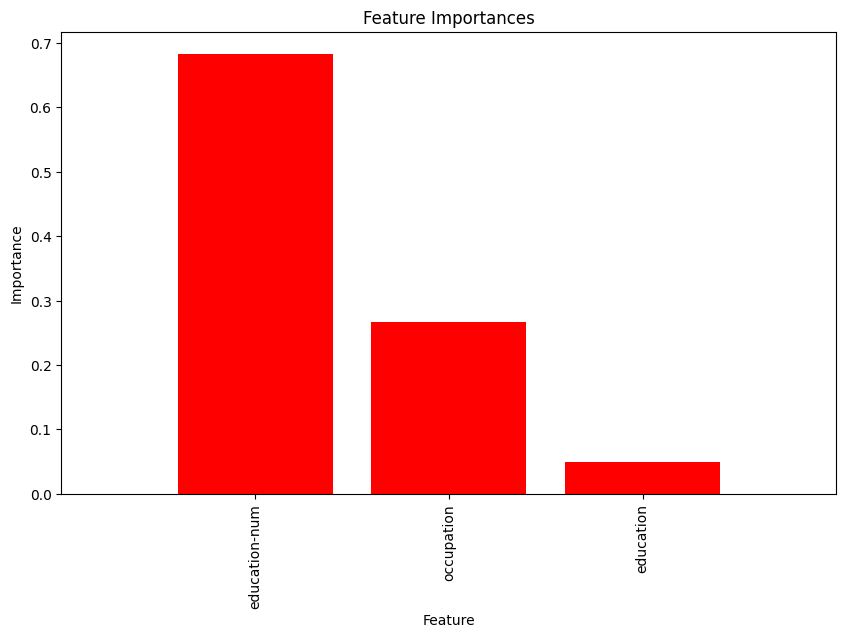

In [ ]:
## TODO : display the plot
plot_explained_variance(gb_classifier, train_X)


**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why?

## [OPTIONAL] Implement Tree from scratch


In [ ]:
n_samples = 100000 # our implementation took ~1 min with this amount of samples, you can reduce the number if neccessary
X_train, X_test, y_train, y_test = train_X.to_numpy()[:n_samples], test_X.to_numpy(), train_y.to_numpy()[:n_samples], test_y.to_numpy()


Next, we will implement a simple decision tree classifier ourselves.
We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split in $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Implement a function `gini_impurity(y)` that computes the Gini impurity for an array of labels `y`.
2. Implement a function `weighted_difference(y, split)`, that calculates the removed Gini impurity for a given boolean array `split` and `y`.
3. Implement a function `find_best_split`, that performs an exhaustive search over all possible splits, i.e. for all features in x and all values of these features.

Note: We have converted the training data to numpy above. Please use these arrays for the task. During debugging, it might be a good idea to reduce the number of data points via the n_samples argument above to speed up computations.

### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.


In [ ]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold


class Leaf:
    def __init__(self, label):
        self.label = label

In [ ]:
# TODO: implement the function build_tree and predict_tree

# Implement recursive tree function
def build_tree(x, y, current_depth, max_depth=3, n_labels=2):
    pass


def predict_tree(node, x):
    pass

In [ ]:
# Build tree
tree = build_tree(X_train, y_train, current_depth=0, max_depth=3, n_labels=2)
predictions = predict_tree(tree, X_test)
predictions

In [ ]:
# Calculate training and test scores
print('Accuracy Training: ', accuracy_score(y_train, predict_tree(tree, X_train)))
print('Accuracy: ', accuracy_score(test_y, predictions))
print('Precision: ', precision_score(test_y, predictions, average='macro'))
print('Recall: ', recall_score(test_y, predictions, average='macro'))

## Prepare for deep learning
### Add all the necessary training functions
*You can reuse them from previous practical exercises*

In [ ]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3

def accuracy(correct, total):
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct/total


In [ ]:
def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """
    # Todo
    train_loss = 0
    correct = 0
    total = 0

    model.train()

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        data = data.float()

        # Forward pass
        output = model(data)
        loss  = loss_fn(output, target)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
        total += target.size(0)


    avg_train_loss = train_loss / len(dataloader)
    avg_train_accuracy = accuracy(correct,total)

    return avg_train_loss, avg_train_accuracy


def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # Todo
    val_loss = 0
    total = 0
    correct = 0

    model.eval()

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        data = data.float()

        #forward pass
        output = model(data)
        loss = loss_fn(output, target)

        val_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
        total += target.size(0)

    avg_val_loss = val_loss / len(dataloader)
    avg_val_accuracy = accuracy(correct, total)

    return avg_val_loss, avg_val_accuracy

In [ ]:
#TODO write a run_training function that
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3
#from tqdm import trange


def train_model(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(train_dataloader, optimizer, model, loss_function, device)
        val_loss, val_accuracy = validate(val_dataloader, model, loss_function, device)

        print(f'{epoch+1}/{num_epochs}, Training Loss : {train_loss:.4f}, Validation Loss : {val_loss:.4f}')
        print(f'{epoch+1}/{num_epochs}, Training Accuracy : {train_accuracy:.4f}, Validation Accuracy : {val_accuracy:.4f}')


        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [ ]:
# TODO write a plot_model_progress function
## It should plot epochs vs metric progress
## Hint - you can use yours from practical 2 or 3

def plot_model_progress(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Dynamic y-axis limits for loss
    loss_min = min(min(train_losses), min(val_losses))
    loss_max = max(max(train_losses), max(val_losses))
    loss_padding = (loss_max - loss_min) * 0.1

    # Dynamic y-axis limits for accuracy
    acc_min = min(min(train_accs), min(val_accs))
    acc_max = max(max(train_accs), max(val_accs))
    acc_padding = (acc_max - acc_min) * 0.1

    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.ylim([loss_min - loss_padding, loss_max + loss_padding])

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.ylim([acc_min - acc_padding, acc_max + acc_padding])

    plt.tight_layout()
    plt.show()



### Convert a pandas dataframe to a PyTorch dataset

In [ ]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes,
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        self.x = df_x.to_numpy().astype(np.float32) if not isinstance(df_x, np.ndarray) else df_x.astype(np.float32)
        self.y = df_y.to_numpy().astype(np.int64) if not isinstance(df_y, np.ndarray) else df_y
        self.mean = mean
        self.std = std
        self.normalise = normalise


    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
      x = self.x[index]
      y = self.y[index]

      if self.normalise and self.mean is not None and self.std is not None:
          x = (x - self.mean) / self.std

      # Convert y to a tensor directly here
      x = torch.from_numpy(x)
      y = torch.tensor(y, dtype=torch.long)  # Create tensor directly here

      return x, y


In [ ]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical
## Hint : the response variable should be of datatype integer


def identify_categorical_columns(df):
    # Categorical columns are often object or category types
    categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return categorical


categorical_columns = identify_categorical_columns(train_X)
exclude_columns = categorical_columns

numeric_columns = train_X.columns.difference(exclude_columns)  # Get numeric columns by excluding categorical and target
train_mean = train_X[numeric_columns].mean()
train_std = train_X[numeric_columns].std()

# Print the computed means and standard deviations
print("Mean of training data (numeric features):", train_mean)
print("Standard deviation of training data (numeric features):", train_std)

# Ensure the target column is integer if it's categorical
#train_y = train_y.astype(int)



Mean of training data (numeric features): education        10.287853
education-num    10.080544
occupation        6.573633
dtype: float64
Standard deviation of training data (numeric features): education        3.871331
education-num    2.575202
occupation       4.227614
dtype: float64


In [ ]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!


train_dataset = TabularDataset(train_X, train_y, mean=train_mean.values, std=train_std.values, normalise=True)
test_dataset = TabularDataset(test_X, test_y, mean=train_mean.values, std=train_std.values, normalise=True)


## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


## Logistic regression

In [ ]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)


    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        outputs = self.linear(x)

        return outputs

In [ ]:
## TODO define model, loss and optimizers
## don't forget to move everything for the correct devices
##
import torch.optim as optim
train_y_tensor = torch.tensor(train_y)

output_dim = len(torch.unique(train_y_tensor))
input_dim = train_X.shape[1]


lr=0.001
model = LR(input_dim, output_dim)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(device)



LR(
  (linear): Linear(in_features=3, out_features=2, bias=True)
)

In [ ]:
## TODO train the network
num_epochs = 30
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Device configuration
model.to(device)

# Start training
# Assuming your run_training function has already collected these metrics
LR_train_loss_history, LR_val_loss_history, LR_train_accuracy_history, LR_val_accuracy_history = train_model(model, optimizer, loss_function, device, num_epochs, train_loader, val_loader)

1/30, Training Loss : 0.9514, Validation Loss : 0.8911
1/30, Training Accuracy : 0.2477, Validation Accuracy : 0.2598
2/30, Training Loss : 0.8392, Validation Loss : 0.7926
2/30, Training Accuracy : 0.2787, Validation Accuracy : 0.3077
3/30, Training Loss : 0.7520, Validation Loss : 0.7157
3/30, Training Accuracy : 0.3534, Validation Accuracy : 0.4477
4/30, Training Loss : 0.6848, Validation Loss : 0.6564
4/30, Training Accuracy : 0.5283, Validation Accuracy : 0.6281
5/30, Training Loss : 0.6339, Validation Loss : 0.6122
5/30, Training Accuracy : 0.6846, Validation Accuracy : 0.7331
6/30, Training Loss : 0.5958, Validation Loss : 0.5791
6/30, Training Accuracy : 0.7526, Validation Accuracy : 0.7737
7/30, Training Loss : 0.5677, Validation Loss : 0.5547
7/30, Training Accuracy : 0.7771, Validation Accuracy : 0.7737
8/30, Training Loss : 0.5469, Validation Loss : 0.5367
8/30, Training Accuracy : 0.7769, Validation Accuracy : 0.7737
9/30, Training Loss : 0.5316, Validation Loss : 0.5234
9

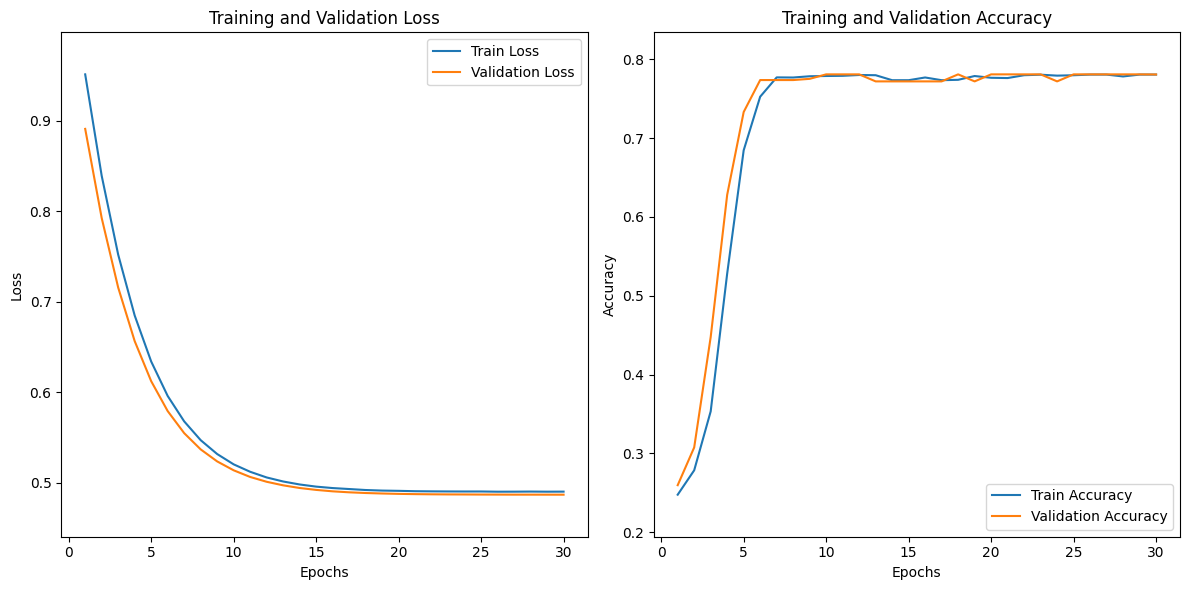

In [ ]:
## todo - plot epochs vs loss with plot_model_progress
plot_model_progress(LR_train_loss_history, LR_val_loss_history, LR_train_accuracy_history, LR_val_accuracy_history)



## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [ ]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity

        )

        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(input_dim, input_dim // 2),  # First linear layer from input_dim to input_dim // 2
            nn.ReLU(),                             # ReLU activation
            nn.Linear(input_dim // 2, input_dim // 4),  # Second linear layer from input_dim // 2 to input_dim // 4
            nn.ReLU(),                             # ReLU activation
            nn.Linear(input_dim // 4, output_dim)  #

        )


    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO
        x = self.network(x)  # Pass the input through the sequential model
        return x

In [ ]:
## TODO : define model, optimizer, cross entropy loss,
## put model to the device, and train mode
## you can optionally try to add regularization
lr=0.001
model = TabularNetwork(input_dim, output_dim)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)


In [ ]:
## TODO : Train model
## TODO : Train model
num_epochs = 30
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Device configuration
model.to(device)

# Start training
MLP_train_loss_history, MLP_val_loss_history, MLP_train_accuracy_history, MLP_val_accuracy_history = train_model(model, optimizer, loss_function, device, num_epochs, train_loader, val_loader,)


1/30, Training Loss : 0.6693, Validation Loss : 0.6473
1/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
2/30, Training Loss : 0.6300, Validation Loss : 0.6145
2/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
3/30, Training Loss : 0.6021, Validation Loss : 0.5917
3/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
4/30, Training Loss : 0.5833, Validation Loss : 0.5765
4/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
5/30, Training Loss : 0.5708, Validation Loss : 0.5667
5/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
6/30, Training Loss : 0.5629, Validation Loss : 0.5606
6/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
7/30, Training Loss : 0.5579, Validation Loss : 0.5569
7/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
8/30, Training Loss : 0.5551, Validation Loss : 0.5549
8/30, Training Accuracy : 0.7593, Validation Accuracy : 0.7588
9/30, Training Loss : 0.5535, Validation Loss : 0.5537
9

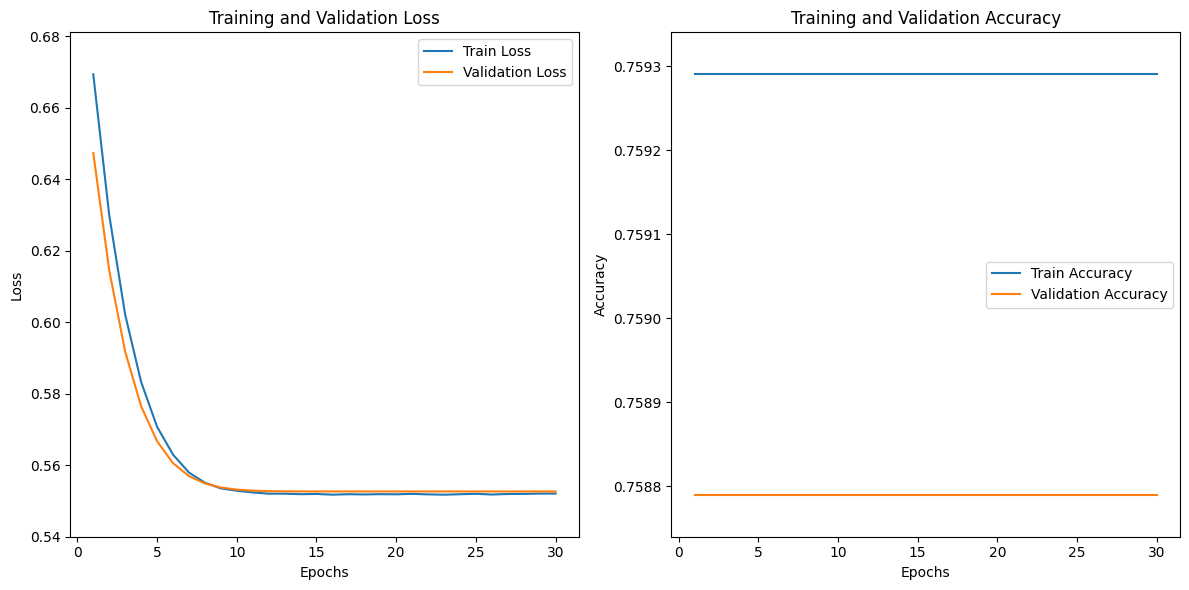

In [ ]:
## todo - plot epochs vs loss with plot_model_progress
plot_model_progress(MLP_train_loss_history, MLP_val_loss_history, MLP_train_accuracy_history, MLP_val_accuracy_history)

In [ ]:
## todo - plot epochs and accuracy with plot_model_progress

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why?


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimizer. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/